In [13]:
# example.ipynb

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

## 1. Define the System Dynamics

We define a unicycle-like robot model:
- State: (x, y, theta)
- Control: (v, omega) - linear and angular velocity
- Disturbance: (w1, w2, w3)

In [14]:
# Time step
tau = 1.0

# Transition function: x_next = f(x, u, w)
def f(x, u, w):
    """System dynamics for unicycle robot."""
    x_next = np.zeros(3)
    x_next[0] = x[0] + tau * (u[0] * np.cos(x[2]) + w[0])
    x_next[1] = x[1] + tau * (u[0] * np.sin(x[2]) + w[1])
    z_next = x[2] + tau * (u[1] + w[2])
    # Wrap theta to [-pi, pi]
    x_next[2] = ((z_next + np.pi) % (2 * np.pi)) - np.pi
    return x_next

# Jacobian of f with respect to x (evaluated at control u)
def Jx(u):
    """Jacobian df/dx - accounts for state uncertainty propagation."""
    return np.array([
        [1, 0, tau * abs(u[0])],
        [0, 1, tau * abs(u[0])],
        [0, 0, 1]
    ], dtype=float)

# Jacobian of f with respect to w (disturbance)
def Jw(u):
    """Jacobian df/dw - accounts for disturbance uncertainty propagation."""
    return np.array([
        [tau, 0, 0],
        [0, tau, 0],
        [0, 0, tau]
    ], dtype=float)

## 2. Define the State, Control, and Disturbance Spaces

In [15]:
# State bounds: [min, max] for each dimension
# X = [x, y, theta]
X_bounds = np.array([
    [0.0, 10.0],    # x: 0 to 10
    [0.0, 10.0],    # y: 0 to 10
    [-np.pi, np.pi] # theta: -pi to pi
])

# Control bounds: [min, max] for each dimension
# U = [v, omega]
U_bounds = np.array([
    [0.25, 1.0],  # v: 0.25 to 1
    [-1.0, 1.0]   # omega: -1 to 1
])

# Disturbance bounds: [min, max] for each dimension
W_bounds = np.array([
    [-0.05, 0.05],  # w1
    [-0.05, 0.05],  # w2
    [-0.05, 0.05]   # w3
])

# Discretization: cells per dimension
cells_per_dim_x = np.array([40, 40, 30])  # NX1, NX2, NX3
cells_per_dim_u = np.array([3, 5])         # NU1, NU2

# Angular dimensions (0-indexed)
angular_dims_x = [2]  # theta is angular

print(f"State space: {np.prod(cells_per_dim_x)} discrete states")
print(f"Control space: {np.prod(cells_per_dim_u)} discrete controls")

State space: 48000 discrete states
Control space: 15 discrete controls


## 3. Define the Specification Automaton

The specification defines the desired behavior:
- Start in state 'a' (nothing reached)
- Visit R1 or R2 (states 'b' or 'c')
- Then reach R3 (accepting state 'd')
- Avoid R4 (obstacle - leads to trash state 'e')

In [16]:
from Automaton import Automaton

# Specification map: SpecMap[current_spec_state][label] = next_spec_state
# Labels: 0=nothing, 1=R1, 2=R2, 3=R3, 4=R4(obstacle)
SpecMap = {
    ('a', 0): 'a',  # nothing -> stay in 'a'
    ('a', 1): 'b',  # reached R1 -> go to 'b'
    ('a', 2): 'c',  # reached R2 -> go to 'c'
    ('a', 3): 'e',  # reached R3 without R1/R2 -> trash
    ('a', 4): 'e',  # hit obstacle -> trash
    
    ('b', 0): 'b',  # nothing -> stay in 'b'
    ('b', 1): 'b',  # R1 again -> stay in 'b'
    ('b', 2): 'e',  # R2 after R1 -> trash (only one region needed)
    ('b', 3): 'd',  # reached R3 after R1 -> accepting!
    ('b', 4): 'e',  # hit obstacle -> trash
    
    ('c', 0): 'c',  # nothing -> stay in 'c'
    ('c', 1): 'e',  # R1 after R2 -> trash
    ('c', 2): 'c',  # R2 again -> stay in 'c'
    ('c', 3): 'd',  # reached R3 after R2 -> accepting!
    ('c', 4): 'e',  # hit obstacle -> trash
    
    ('d', 0): 'd',  # accepting is absorbing
    ('d', 1): 'd',
    ('d', 2): 'd',
    ('d', 3): 'd',
    ('d', 4): 'd',
    
    ('e', 0): 'e',  # trash is absorbing
    ('e', 1): 'e',
    ('e', 2): 'e',
    ('e', 3): 'e',
    ('e', 4): 'e',
}

spec_automaton = Automaton(
    transition=SpecMap,
    initial_state='a',
    final_states=['d'],
    total_states=5
)

print(f"Specification automaton states: {spec_automaton.state_list}")
print(f"Initial state: {spec_automaton.initial_state}")
print(f"Final states: {spec_automaton.final_states}")

Specification automaton states: ['a', 'b', 'c', 'd', 'e']
Initial state: a
Final states: ['d']


## 4. Define the Regions and Labeling Relation

The regions define where in the state space each label applies.

In [17]:
# Region definitions: {label: (min_bounds, max_bounds)}
# Label 0 = default (no region)
# Labels 1-4 correspond to regions R1-R4
regions = {
    1: (np.array([4.0, 8.5, -np.pi]), np.array([5.0, 9.5, np.pi])),   # R1
    2: (np.array([8.5, 2.0, -np.pi]), np.array([9.5, 3.0, np.pi])),   # R2
    3: (np.array([2.0, 0.5, -np.pi]), np.array([3.0, 1.5, np.pi])),   # R3 (target)
    4: (np.array([3.0, 3.0, -np.pi]), np.array([7.0, 7.0, np.pi])),   # R4 (obstacle)
}

def relation(min_state, max_state, region_bounds):
    """Check if a cell intersects with a region."""
    region_min, region_max = region_bounds
    # Check intersection in first 2 dimensions (x, y)
    for d in range(2):
        if max_state[d] < region_min[d] or min_state[d] > region_max[d]:
            return False
    return True

# Sets for labeling: label -> region_bounds (None means default)
sets = {
    0: None,  # Default label (no region)
    1: (regions[1][0], regions[1][1]),
    2: (regions[2][0], regions[2][1]),
    3: (regions[3][0], regions[3][1]),
    4: (regions[4][0], regions[4][1]),
}

print("Regions defined:")
for label, bounds in regions.items():
    print(f"  R{label}: x=[{bounds[0][0]:.1f}, {bounds[1][0]:.1f}], y=[{bounds[0][1]:.1f}, {bounds[1][1]:.1f}]")

Regions defined:
  R1: x=[4.0, 5.0], y=[8.5, 9.5]
  R2: x=[8.5, 9.5], y=[2.0, 3.0]
  R3: x=[2.0, 3.0], y=[0.5, 1.5]
  R4: x=[3.0, 7.0], y=[3.0, 7.0]


## 5. Build the Symbolic Controller

In [ ]:
from SymbolicController import SymbolicController

# Create the symbolic controller
model_dir = './Models_example'

controller = SymbolicController(
    f=f,
    Jx=Jx,
    Jw=Jw,
    X_bounds=X_bounds,
    U_bounds=U_bounds,
    W_bounds=W_bounds,
    cells_per_dim_x=cells_per_dim_x,
    cells_per_dim_u=cells_per_dim_u,
    angular_dims_x=angular_dims_x,
    SpecificationAutomaton=spec_automaton,
    relation=relation,
    sets=sets,
    model_dir=model_dir
)

print("SymbolicController initialized.")

Attempting to load existing symbolic model from file...


In [19]:
# Start the controller synthesis
controller.start(is_reachability=True, max_iter=1000)

print(f"\nController synthesis complete.")
print(f"V shape: {controller.V.shape}")
print(f"h shape: {controller.h.shape}")

Attempting to load existing controller results from file...
✗ No existing controller results found. Computing new controller...
  Initial domain: 48000 states
  Trash specification states: {'e'}
    ApplySecurity Phase 1 (system states): Initial size: 48000
    ApplySecurity Phase 1 converged after 1 iterations: 48000 safe system states
    ApplySecurity Phase 2 (product states): 192000 states
    ApplySecurity converged after 1 iterations
  After ApplySecurity: 192000 safe states
  Target states (accepting): 48000
    ApplySecurity Phase 1 converged after 1 iterations: 48000 safe system states
    ApplySecurity Phase 2 (product states): 192000 states
    ApplySecurity converged after 1 iterations
  After ApplySecurity: 192000 safe states
  Target states (accepting): 48000
    ApplyReachability: Initial target set size: 48000
    ApplyReachability: Initial target set size: 48000
    ApplyReachability converged after 1 iterations
  After ApplyReachability: 48000 reachable states
  Contr

## 6. Visualize the Winning Domain

In [20]:
# Count winning states per specification state
for spec_idx, spec_name in enumerate(spec_automaton.state_list):
    winning_count = np.sum(controller.V[spec_idx, :])
    print(f"Winning states for spec '{spec_name}': {winning_count}")

# Total winning states
total_winning = np.sum(controller.V)
total_states = controller.V.size
print(f"\nTotal winning: {total_winning} / {total_states} ({100*total_winning/total_states:.1f}%)")

Winning states for spec 'a': 0
Winning states for spec 'b': 0
Winning states for spec 'c': 0
Winning states for spec 'd': 48000
Winning states for spec 'e': 0

Total winning: 48000 / 240000 (20.0%)


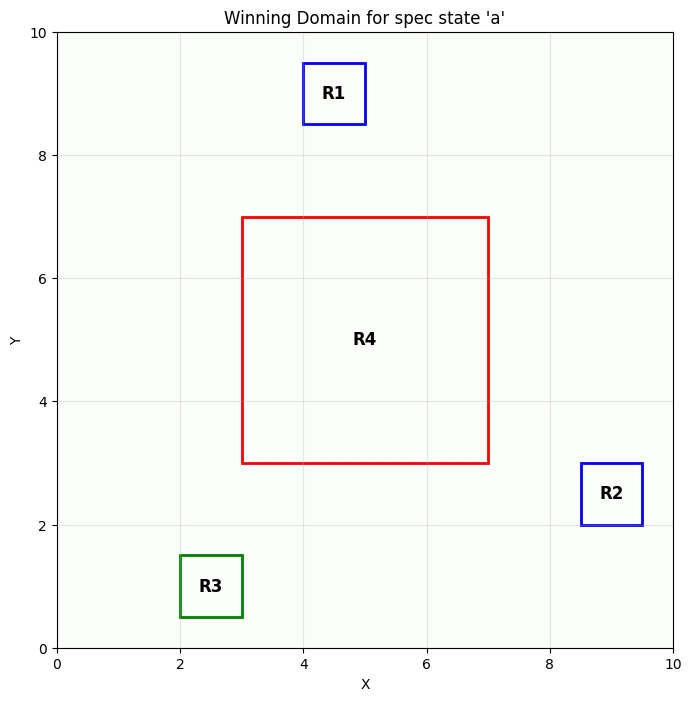

In [21]:
# Visualize winning domain for initial spec state 'a' (2D projection, fixed theta slice)
def plot_winning_domain_2d(controller, spec_state_name, k_slice=15):
    """Plot winning domain as 2D projection for a given specification state."""
    disc = controller.Discretisation
    spec_idx = spec_automaton.get_state_index(spec_state_name)
    
    NX1 = cells_per_dim_x[0]
    NX2 = cells_per_dim_x[1]
    NX3 = cells_per_dim_x[2]
    
    # Create grid for visualization
    grid = np.zeros((NX1, NX2))
    
    for i in range(NX1):
        for j in range(NX2):
            # Check if any theta slice is winning
            for k in range(NX3):
                state_idx = disc.coord_to_idx(np.array([i, j, k]))
                if controller.V[spec_idx, state_idx]:
                    grid[i, j] = 1
                    break
    
    plt.figure(figsize=(10, 8))
    plt.imshow(grid.T, origin='lower', extent=[0, 10, 0, 10], cmap='Greens', alpha=0.5)
    
    # Draw regions
    for label, (rmin, rmax) in regions.items():
        color = 'green' if label == 3 else ('red' if label == 4 else 'blue')
        rect = plt.Rectangle((rmin[0], rmin[1]), rmax[0]-rmin[0], rmax[1]-rmin[1],
                             fill=False, edgecolor=color, linewidth=2)
        plt.gca().add_patch(rect)
        plt.text((rmin[0]+rmax[0])/2, (rmin[1]+rmax[1])/2, f"R{label}",
                ha='center', va='center', fontsize=12, fontweight='bold')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f"Winning Domain for spec state '{spec_state_name}'")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_winning_domain_2d(controller, 'a')

## 7. Simulate Trajectories

In [22]:
def generate_disturbance(W_bounds):
    """Generate random disturbance within bounds."""
    return np.random.uniform(W_bounds[:, 0], W_bounds[:, 1])

def find_winning_start_states(controller, spec_state_name):
    """Find all winning start states for a given specification state."""
    spec_idx = spec_automaton.get_state_index(spec_state_name)
    disc = controller.Discretisation
    
    winning_states = []
    for sys_state in range(disc.N_x):
        if controller.V[spec_idx, sys_state]:
            winning_states.append(sys_state)
    
    return winning_states

# Find winning states
winning_starts = find_winning_start_states(controller, 'a')
print(f"Found {len(winning_starts)} winning start states for spec 'a'")

Found 0 winning start states for spec 'a'


In [23]:
def simulate_trajectory(controller, start_state_idx, start_spec, max_steps=50):
    """Simulate a trajectory using the synthesized controller."""
    disc = controller.Discretisation
    
    # Get continuous start position (cell center)
    x = disc.idx_to_continuous(start_state_idx, disc.X_bounds, disc.dx_cell)
    
    trajectory = [x.copy()]
    spec_states = [start_spec]
    context = start_spec
    
    for step in range(max_steps):
        # Get discrete state
        cell_idx = disc.continuous_to_cell_idx(x)
        state_idx = disc.coord_to_idx(cell_idx)
        
        # Get control from controller
        spec_idx = spec_automaton.get_state_index(context)
        control_idx = int(controller.h[spec_idx, state_idx])
        
        if control_idx < 0:
            print(f"No control at step {step}, state_idx={state_idx}, spec={context}")
            break
        
        # Get continuous control
        control_coord = disc.control_idx_to_coord(control_idx)
        u = disc.U_bounds[:, 0] + (control_coord + 0.5) * disc.du_cell
        
        # Generate disturbance and step
        w = generate_disturbance(W_bounds)
        x = f(x, u, w)
        
        trajectory.append(x.copy())
        
        # Check bounds
        if not (0 <= x[0] <= 10 and 0 <= x[1] <= 10):
            print(f"Out of bounds at step {step+1}")
            break
        
        # Update specification state
        cell_idx = disc.continuous_to_cell_idx(x)
        state_idx = disc.coord_to_idx(cell_idx)
        labels = controller.Controller.Automaton.Labeling[state_idx]
        
        for label in labels:
            next_spec = spec_automaton.get_next_state(context, label)
            if next_spec is not None:
                context = next_spec
                break
        
        spec_states.append(context)
        
        if context == 'd':
            print(f"Reached accepting state 'd' at step {step+1}!")
            break
        elif context == 'e':
            print(f"Entered trash state 'e' at step {step+1}")
            break
    
    return np.array(trajectory), spec_states

In [24]:
# Simulate multiple trajectories
N_trajectories = 5
trajectories = []
all_spec_states = []

for i in range(N_trajectories):
    start_idx = random.choice(winning_starts)
    print(f"\nTrajectory {i+1}: starting from state {start_idx}")
    traj, specs = simulate_trajectory(controller, start_idx, 'a')
    trajectories.append(traj)
    all_spec_states.append(specs)

IndexError: Cannot choose from an empty sequence

In [ ]:
# Plot all trajectories
fig, ax = plt.subplots(figsize=(12, 10))

# Draw regions
for label, (rmin, rmax) in regions.items():
    color = 'green' if label == 3 else ('red' if label == 4 else 'blue')
    alpha = 0.2 if label == 4 else 0.1
    rect = plt.Rectangle((rmin[0], rmin[1]), rmax[0]-rmin[0], rmax[1]-rmin[1],
                         fill=True, facecolor=color, alpha=alpha,
                         edgecolor=color, linewidth=2)
    ax.add_patch(rect)
    ax.text((rmin[0]+rmax[0])/2, (rmin[1]+rmax[1])/2, f"R{label}",
            ha='center', va='center', fontsize=14, fontweight='bold')

# Plot trajectories
colors = plt.cm.tab10(np.linspace(0, 1, N_trajectories))
for i, (traj, specs) in enumerate(zip(trajectories, all_spec_states)):
    ax.plot(traj[:, 0], traj[:, 1], '-', color=colors[i], linewidth=1.5, alpha=0.7)
    ax.scatter(traj[:, 0], traj[:, 1], s=20, color=colors[i], alpha=0.5)
    
    # Mark start
    ax.plot(traj[0, 0], traj[0, 1], 'o', color=colors[i], markersize=12,
            markeredgecolor='black', markeredgewidth=2, label=f'Traj {i+1} start')
    
    # Mark end
    ax.plot(traj[-1, 0], traj[-1, 1], 's', color=colors[i], markersize=12,
            markeredgecolor='black', markeredgewidth=2)

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_title('Simulated Trajectories with Synthesized Controller', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## 8. Summary Statistics

In [ ]:
# Print summary
print("=" * 50)
print("SIMULATION SUMMARY")
print("=" * 50)

successful = 0
for i, specs in enumerate(all_spec_states):
    final_spec = specs[-1]
    traj = trajectories[i]
    status = "SUCCESS" if final_spec == 'd' else ("TRASH" if final_spec == 'e' else "INCOMPLETE")
    if final_spec == 'd':
        successful += 1
    print(f"Trajectory {i+1}: {len(traj)} steps, final spec: '{final_spec}' - {status}")

print(f"\nSuccess rate: {successful}/{N_trajectories} ({100*successful/N_trajectories:.0f}%)")